In [24]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160_000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2022-02-11 09:44:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 142.250.152.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  92.6MB/s    in 2.5s    

2022-02-11 09:44:52 (92.6 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
import pandas as pd

df = pd.read_csv("/tmp/training_cleaned.csv",header = None)
df = df.sample(frac=1)[:training_size]

sentences = df.iloc[:,5].values
labels = df.iloc[:,0].replace(4,1).values

In [4]:
sentences[3], labels[3]

('bridge to therabithia is actually really good. i love the book ', 1)

In [5]:
from sklearn.model_selection import train_test_split

sentences, test_sentences, labels, test_labels = train_test_split(sentences,labels, train_size = 0.9)

In [8]:
sentences[2],test_sentences[2],labels[2],test_labels[2]

('With brian liz sam ryan john and cooper going to starbucks ',
 "and now i'm going to watch Idle Hands, it's free On Demand right now ",
 1,
 1)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length,truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length,truncating=trunc_type)

In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt -O /tmp/glove.6B.100d.txt

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip ./glove.6B.300d.txt

In [23]:
import zipfile 

zip_ref = zipfile.ZipFile("/content/glove.6B.zip")
zip_ref.extractall()

In [25]:
embeddings_index = {};
with open('/content/glove.6B.100d.txt', encoding="utf-8",errors='ignore') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 100)           12852600  
                                                                 
 dropout_1 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 128)           66048     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 16)               

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights=True)

In [41]:
num_epochs = 50
history = model.fit(padded, labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2, callbacks = [early_stop])

print("Training Complete")

Epoch 1/50
4500/4500 - 54s - loss: 0.5703 - accuracy: 0.6971 - val_loss: 0.5286 - val_accuracy: 0.7300 - 54s/epoch - 12ms/step
Epoch 2/50
4500/4500 - 38s - loss: 0.5305 - accuracy: 0.7310 - val_loss: 0.5554 - val_accuracy: 0.7011 - 38s/epoch - 8ms/step
Epoch 3/50
4500/4500 - 38s - loss: 0.5149 - accuracy: 0.7422 - val_loss: 0.5181 - val_accuracy: 0.7406 - 38s/epoch - 8ms/step
Epoch 4/50
4500/4500 - 37s - loss: 0.5038 - accuracy: 0.7503 - val_loss: 0.5138 - val_accuracy: 0.7417 - 37s/epoch - 8ms/step
Epoch 5/50
4500/4500 - 37s - loss: 0.4926 - accuracy: 0.7566 - val_loss: 0.5084 - val_accuracy: 0.7459 - 37s/epoch - 8ms/step
Epoch 6/50
4500/4500 - 39s - loss: 0.4875 - accuracy: 0.7597 - val_loss: 0.5160 - val_accuracy: 0.7450 - 39s/epoch - 9ms/step
Epoch 7/50
4500/4500 - 40s - loss: 0.4811 - accuracy: 0.7636 - val_loss: 0.5088 - val_accuracy: 0.7431 - 40s/epoch - 9ms/step
Epoch 8/50
4500/4500 - 37s - loss: 0.4758 - accuracy: 0.7671 - val_loss: 0.5044 - val_accuracy: 0.7473 - 37s/epoch - 

<Figure size 432x288 with 0 Axes>

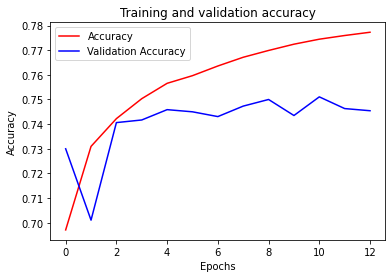

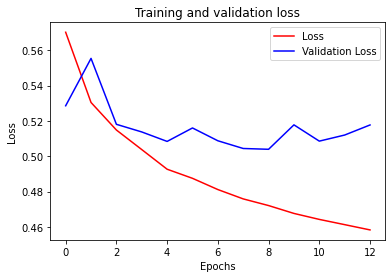

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [46]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 16, 100)           12852600  
                                                                 
 dropout_3 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              49920     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                

In [47]:
num_epochs = 50
history = model_gru.fit(padded, labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2, callbacks = [early_stop])

print("Training Complete")

Epoch 1/50
4500/4500 - 37s - loss: 0.5732 - accuracy: 0.6930 - val_loss: 0.5330 - val_accuracy: 0.7344 - 37s/epoch - 8ms/step
Epoch 2/50
4500/4500 - 31s - loss: 0.5294 - accuracy: 0.7297 - val_loss: 0.5259 - val_accuracy: 0.7358 - 31s/epoch - 7ms/step
Epoch 3/50
4500/4500 - 31s - loss: 0.5130 - accuracy: 0.7419 - val_loss: 0.5139 - val_accuracy: 0.7468 - 31s/epoch - 7ms/step
Epoch 4/50
4500/4500 - 31s - loss: 0.5019 - accuracy: 0.7505 - val_loss: 0.5111 - val_accuracy: 0.7457 - 31s/epoch - 7ms/step
Epoch 5/50
4500/4500 - 31s - loss: 0.4933 - accuracy: 0.7556 - val_loss: 0.5094 - val_accuracy: 0.7459 - 31s/epoch - 7ms/step
Epoch 6/50
4500/4500 - 32s - loss: 0.4859 - accuracy: 0.7611 - val_loss: 0.5169 - val_accuracy: 0.7508 - 32s/epoch - 7ms/step
Epoch 7/50
4500/4500 - 31s - loss: 0.4813 - accuracy: 0.7633 - val_loss: 0.5075 - val_accuracy: 0.7475 - 31s/epoch - 7ms/step
Epoch 8/50
4500/4500 - 31s - loss: 0.4751 - accuracy: 0.7675 - val_loss: 0.5103 - val_accuracy: 0.7477 - 31s/epoch - 7

<Figure size 432x288 with 0 Axes>

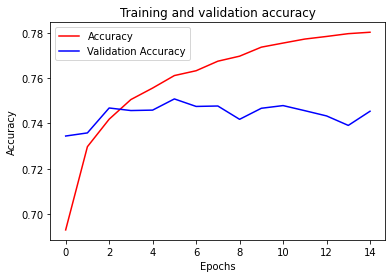

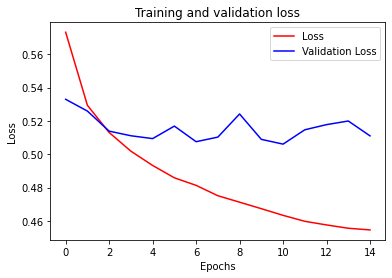

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!